# EfficientNet Clean Framework

This notebook explains the implementation of my ResNet transfer learning framework using the EfficientNet model. Timestamp is 07/07 @ 7 pm. 

In [39]:
import numpy as np
import pandas as pd
import os
import gc
import cv2
import tensorflow as tf
import seaborn as sn
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import Model
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

print(tf.__version__)

2.2.0





 89%|████████▉ | 9752/10982 [01:05<00:07, 170.60it/s]

In [2]:
training = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
print(training.head(10))

     image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   
5  ISIC_0074311  IP_2950485  female        40.0               lower extremity   
6  ISIC_0074542  IP_4698288    male        25.0               lower extremity   
7  ISIC_0075663  IP_6017204  female        35.0                         torso   
8  ISIC_0075914  IP_7622888    male        30.0                         torso   
9  ISIC_0076262  IP_5075533  female        50.0               lower extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign  

In [3]:
print(training["target"].value_counts())

0    32542
1      584
Name: target, dtype: int64


We take a very small sample of 4000 benign data to balance out the 584 malignant data. Note that we are not reading from the competition data but from an already resized dataset (224x224)

In [4]:
m = training[training["target"]==1]
b = training[training["target"]==0].sample(4000)
df = pd.concat([m,b])
df.reset_index(inplace=True)
df.drop(labels=["index", "patient_id", "sex", "age_approx", "anatom_site_general_challenge", "diagnosis", "benign_malignant"], axis=1, inplace=True)
df["image_name"] = "../input/siic-isic-224x224-images/train/" + df["image_name"].astype(str) + ".png"
df.head()

,image_name,target
0,../input/siic-isic-224x224-images/train/ISIC_0...,1
1,../input/siic-isic-224x224-images/train/ISIC_0...,1
2,../input/siic-isic-224x224-images/train/ISIC_0...,1
3,../input/siic-isic-224x224-images/train/ISIC_0...,1
4,../input/siic-isic-224x224-images/train/ISIC_0...,1


After appending the necessary file path details we read in the images and save them in a compressed .npz file. After you reload the .npz file from the disk, treat it as a dictionary (you can save multiple numpy arrays in a npz file, so each of them gets their own key-name. I used "images=imgs" here, so when I access it I use use square-bracket \["images"\] to access that particular array.

In [5]:
imgs = []
labels = []
for index, row in tqdm(df.iterrows()):
    img = cv2.imread(str(row["image_name"]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgs.append(img)
    labels.append(row["target"])
imgs = np.array(imgs)
labels = np.array(labels)
print(imgs.shape)
print(labels.shape)
del m, b, df
gc.collect()

4584it [00:25, 180.68it/s]


(4584, 224, 224, 3)
(4584,)


0

Save the output if you want. May make life easier if you are using image sizes greater than 224x224. EfficientNet is flexible with images sizes, but the defaults can be found here https://tfhub.dev/google/collections/efficientnet/1.

In [6]:
with open("effnet_imgs4k.npz", "wb") as file:
    np.savez_compressed(file, images=imgs)

**Everything before this point need only be run once, assuming you downloaded the images. Save the npz file to a personal dataset and access them that way.**

In [ ]:
with open("effnet_imgs4k.npz", "rb") as file:
    imgs = np.load(file)["images"]

In [ ]:
labels = np.concatenate([np.full(1168,1),np.full(6000,0)])
print(imgs.shape)
print(labels.shape)

Note that we set the random_state in the train-test split as 888. This means the model will be very lucky.

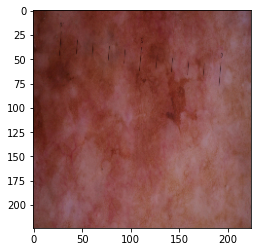

In [7]:
trainX, valX, trainY, valY = train_test_split(imgs, labels, test_size=0.2, random_state=888)
del imgs, labels
gc.collect()
plt.imshow(trainX[0])

In [8]:
train_aug = ImageDataGenerator(rescale=1./255,
                     rotation_range=70,
                     width_shift_range=0.25, 
                     height_shift_range=0.25,
                     shear_range=0.1,
                     channel_shift_range=20,
                     horizontal_flip=True,
                     vertical_flip=True)

val_aug = ImageDataGenerator(rescale=1./255)

I've made the batch size 16 purely because data augmentation seems to yield good results.

In [9]:
train_gen = train_aug.flow(trainX, trainY, batch_size = 16, shuffle = True)
val_gen = val_aug.flow(valX, valY, batch_size = 16, shuffle = False)

Early stop needs some explanation. It basically looks at the validation loss, and when it stops decreasing after two epochs it stops training the model. You can adjust the patience to your liking. Model checkpoint just saves a copy of the model every time a better loss is found.

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', patience=2)
checkpoint = ModelCheckpoint("{val_loss:.2f}-{epoch:02d}.hdf5",monitor = 'val_loss',verbose = 1,save_best_only = True,mode = 'min')

callbacks = [early_stop, checkpoint]

Focal loss is good for very skewed data. Hell if I know how it works. I don't use it in this notebook, but you can use it just by setting loss= focal_loss(). Be sure to add the parentheses.

In [11]:
from tensorflow.python.keras import backend as K
def focal_loss(alpha=0.25,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        
        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = K.pow((1-p_t), gamma)

        # compute the final loss and return
        return K.mean(alpha_factor*modulating_factor*bce, axis=-1)
    return focal_crossentropy

Now we install efficientnet onto our machine.

In [12]:
!pip install git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-u5ip4t8d
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-u5ip4t8d
     |████████████████████████████████| 50 kB 1.4 MB/s eta 0:00:011
  Created wheel for efficientnet: filename=efficientnet-1.1.0-py3-none-any.whl size=18397 sha256=dc367e6c685a3e371f8651b51c025fd1db976d982a74d9670c543657ce462cdc
  Stored in directory: /tmp/pip-ephem-wheel-cache-0ip_squ9/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet


In [13]:
import efficientnet.keras as efn 

This notebook is for EfficientNet B0. There are 8 versions in increasing complexity and effectiveness. I chose to use a Flatten layer here, but other options like global average pooling exist. 

**I froze the entire EfficientNet convolution system so that the classifier (top layer) can be properly trained. In the next section, I unfreeze the last 1-2 blocks of the EffNet system so it can adjust to melanoma features. Everything gets frozen right now because this lets us fine-tune the top layers better and prevents the model from training to heavily in wrong directions.**

In [14]:
effnet = efn.EfficientNetB0(
    include_top=True,
    weights="imagenet",
    input_shape=(224,224,3)
)

effnet.trainable=False

flat = Flatten()(effnet.output)
# gap = GlobalAveragePooling2D()(effnet.output)
final = Dropout(0.4)(flat)
final = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(final)
final = Dropout(0.4)(final)
final = Dense(1, activation="sigmoid")(final)
model = Model(effnet.input,final)
model.summary()

21831680/21826536 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
_____________________________

Note that the trainable parameters are relatively small and that we don't restrict Adam's learning rate. Later on when we unfreeze parts of EffNet, we make the learning rate really really small because EffNet has already learned features on millions of images; we just have to fine-tune very slightly at this point. The top layers get trained for only a few epochs for now.

In [15]:
model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")

history = model.fit_generator(
    train_gen,
    steps_per_epoch = trainX.shape[0] // 16,
    epochs = 3, 
    validation_data = val_gen,
    validation_steps = valX.shape[0] // 16
)


Epoch 1/3
229/229 [==============================] - 48s 211ms/step - loss: 0.4643 - accuracy: 0.8732 - val_loss: 0.4219 - val_accuracy: 0.8564
Epoch 2/3
229/229 [==============================] - 45s 197ms/step - loss: 0.3767 - accuracy: 0.8767 - val_loss: 0.4140 - val_accuracy: 0.8564
Epoch 3/3
229/229 [==============================] - 45s 199ms/step - loss: 0.3769 - accuracy: 0.8762 - val_loss: 0.4094 - val_accuracy: 0.8564


Block 7 (the last convolutional block) begins on layer 214. FYI the second last block begins on 156. We unfreeze the last block and train until no loss decrease is detected for 2 epochs.

In [16]:
for layer in effnet.layers[214:]:
   layer.trainable = True
for i, layer in enumerate(effnet.layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 stem_conv False
2 stem_bn False
3 stem_activation False
4 block1a_dwconv False
5 block1a_bn False
6 block1a_activation False
7 block1a_se_squeeze False
8 block1a_se_reshape False
9 block1a_se_reduce False
10 block1a_se_expand False
11 block1a_se_excite False
12 block1a_project_conv False
13 block1a_project_bn False
14 block2a_expand_conv False
15 block2a_expand_bn False
16 block2a_expand_activation False
17 block2a_dwconv False
18 block2a_bn False
19 block2a_activation False
20 block2a_se_squeeze False
21 block2a_se_reshape False
22 block2a_se_reduce False
23 block2a_se_expand False
24 block2a_se_excite False
25 block2a_project_conv False
26 block2a_project_bn False
27 block2b_expand_conv False
28 block2b_expand_bn False
29 block2b_expand_activation False
30 block2b_dwconv False
31 block2b_bn False
32 block2b_activation False
33 block2b_se_squeeze False
34 block2b_se_reshape False
35 block2b_se_reduce False
36 block2b_se_expand False
37 block2b_se_excite False
38 bloc

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

And now there's several million more trainable parameters.

In [18]:
opt = keras.optimizers.Adam(lr=1e-5)
# opt = keras.optimizers.Adamax(learning_rate=1e-5)
# opt = keras.optimizers.Adagrad(learning_rate=1e-3)
auc = keras.metrics.AUC()

I don't use AUC in this demo, but to implement it all you need to do is to set metrics=\[auc\]

In [19]:
model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=opt)

history = model.fit_generator(
    train_gen,
    steps_per_epoch = trainX.shape[0] // 16,
    epochs = 10, 
    validation_data = val_gen,
    validation_steps = valX.shape[0] // 16,
    callbacks = callbacks
)

Epoch 1/10
229/229 [==============================] - ETA: 0s - loss: 0.3803 - accuracy: 0.8762
Epoch 00001: val_loss improved from inf to 0.41072, saving model to 0.41-01.hdf5
229/229 [==============================] - 47s 205ms/step - loss: 0.3803 - accuracy: 0.8762 - val_loss: 0.4107 - val_accuracy: 0.8564
Epoch 2/10
229/229 [==============================] - ETA: 0s - loss: 0.3769 - accuracy: 0.8765
Epoch 00002: val_loss improved from 0.41072 to 0.40737, saving model to 0.41-02.hdf5
229/229 [==============================] - 45s 198ms/step - loss: 0.3769 - accuracy: 0.8765 - val_loss: 0.4074 - val_accuracy: 0.8564
Epoch 3/10
229/229 [==============================] - ETA: 0s - loss: 0.3744 - accuracy: 0.8765
Epoch 00003: val_loss improved from 0.40737 to 0.40256, saving model to 0.40-03.hdf5
229/229 [==============================] - 44s 191ms/step - loss: 0.3744 - accuracy: 0.8765 - val_loss: 0.4026 - val_accuracy: 0.8564
Epoch 4/10
229/229 [==============================] - ETA: 

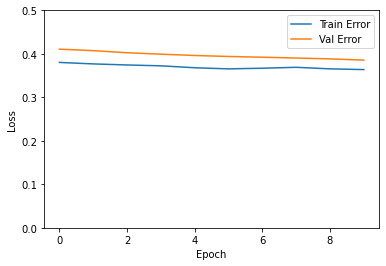

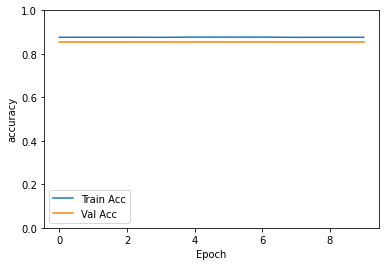

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(hist['epoch'], hist['loss'], label='Train Error')
plt.plot(hist['epoch'], hist['val_loss'], label='Val Error')
plt.ylim([0, 0.5])
plt.legend()

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.plot(hist['epoch'], hist['accuracy'], label='Train Acc')
plt.plot(hist['epoch'], hist['val_accuracy'], label='Val Acc')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [21]:
del trainX, trainY, valX, valY
gc.collect()

5168

Now for predicting. I print out the first 50 predictions just to make sure things are going right.

In [ ]:
test_images = np.load('../input/siimisic-melanoma-resized-images/x_test_224.npy')
print(test_images.shape)

In [48]:
print(test_images.shape)

(10982, 224, 224, 3)


In [50]:
def predict():
    predictions = np.empty(0)
    k = test_images.shape[0]
    i = 0
    p_bar = tqdm(total=test_images.shape[0])
    while True:
        images=[]
        for j in range(64):
            p_bar.update(1)
            if(i>=k):
                pred=model.predict(np.array(images))
                pred=np.squeeze(pred)
                predictions = np.concatenate((predictions, pred))
                print(predictions.shape)
                return predictions
            images.append(test_images[i].astype(np.float32)/255.) 
            i+=1
            
        pred=model.predict(np.array(images))
        pred=np.squeeze(pred)
        predictions = np.concatenate((predictions, pred))
        
predictions = predict()

(10982,)


In [51]:
results = pd.read_csv('../input/siim-isic-melanoma-classification/sample_submission.csv')
results['target'] = predictions
results.to_csv('effnet.csv', header=True, index=False)